In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from AMPpred_MFA.lib.Encoding import easy_encoding
from AMPpred_MFA.lib.Vocab import load_vocab
from AMPpred_MFA.lib.Data import load_dataset, get_data_iter, get_data_loader
from AMPpred_MFA.models.Model import load_model
from AMPpred_MFA.models.AMPpred_MFA import Model, Config
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_path_attention_visual = '../figures/attention visualization/A0A1P8AQ95' # 保存路径
os.makedirs(save_path_attention_visual, exist_ok=True)

In [2]:
vocab_path = './trained_model/vocab.json'
model_path = './trained_model/model.pth'
vocab = load_vocab(vocab_path)
config = Config()
config.k_mer = 1
config.batch_size = 32
config.embed_padding_idx = vocab[config.padding_token]
config.feature_dim = 400
config.vocab_size = len(vocab)
model = Model(config)
load_model(model, model_path)
model.eval()
fastas = np.array([
    ('A0A1P8AQ95','MTKNMTKKKMGLMSPNIAAFVLPMLLVLFTISSQVEVVESTGRKLSWAFNGAPIVFTPPSSSCGGSPAAVMASEWMPRRPCRRTRPPGTNIPVSQSP'),
    ])
data_x = easy_encoding(fastas, 'mixed', vocab,
                        config.k_mer, config.padding_size)

Loading vocabulary...
Vocabulary has been loaded.
Loading model...
Model has been loaded.


In [3]:
out = model(data_x)
attention2 = model.attention_wight2.cpu().detach().numpy()
attention2_inputs = model.attention_wight2_inputs.cpu().detach().numpy().reshape(config.padding_size, -1)
attention2_outputs = model.attention_wight2_outputs.cpu().detach().numpy().reshape(config.padding_size, -1)
print(attention2.shape)
print(attention2_inputs.shape)
print(attention2_outputs.shape)

(4, 100, 100)
(100, 60)
(100, 60)


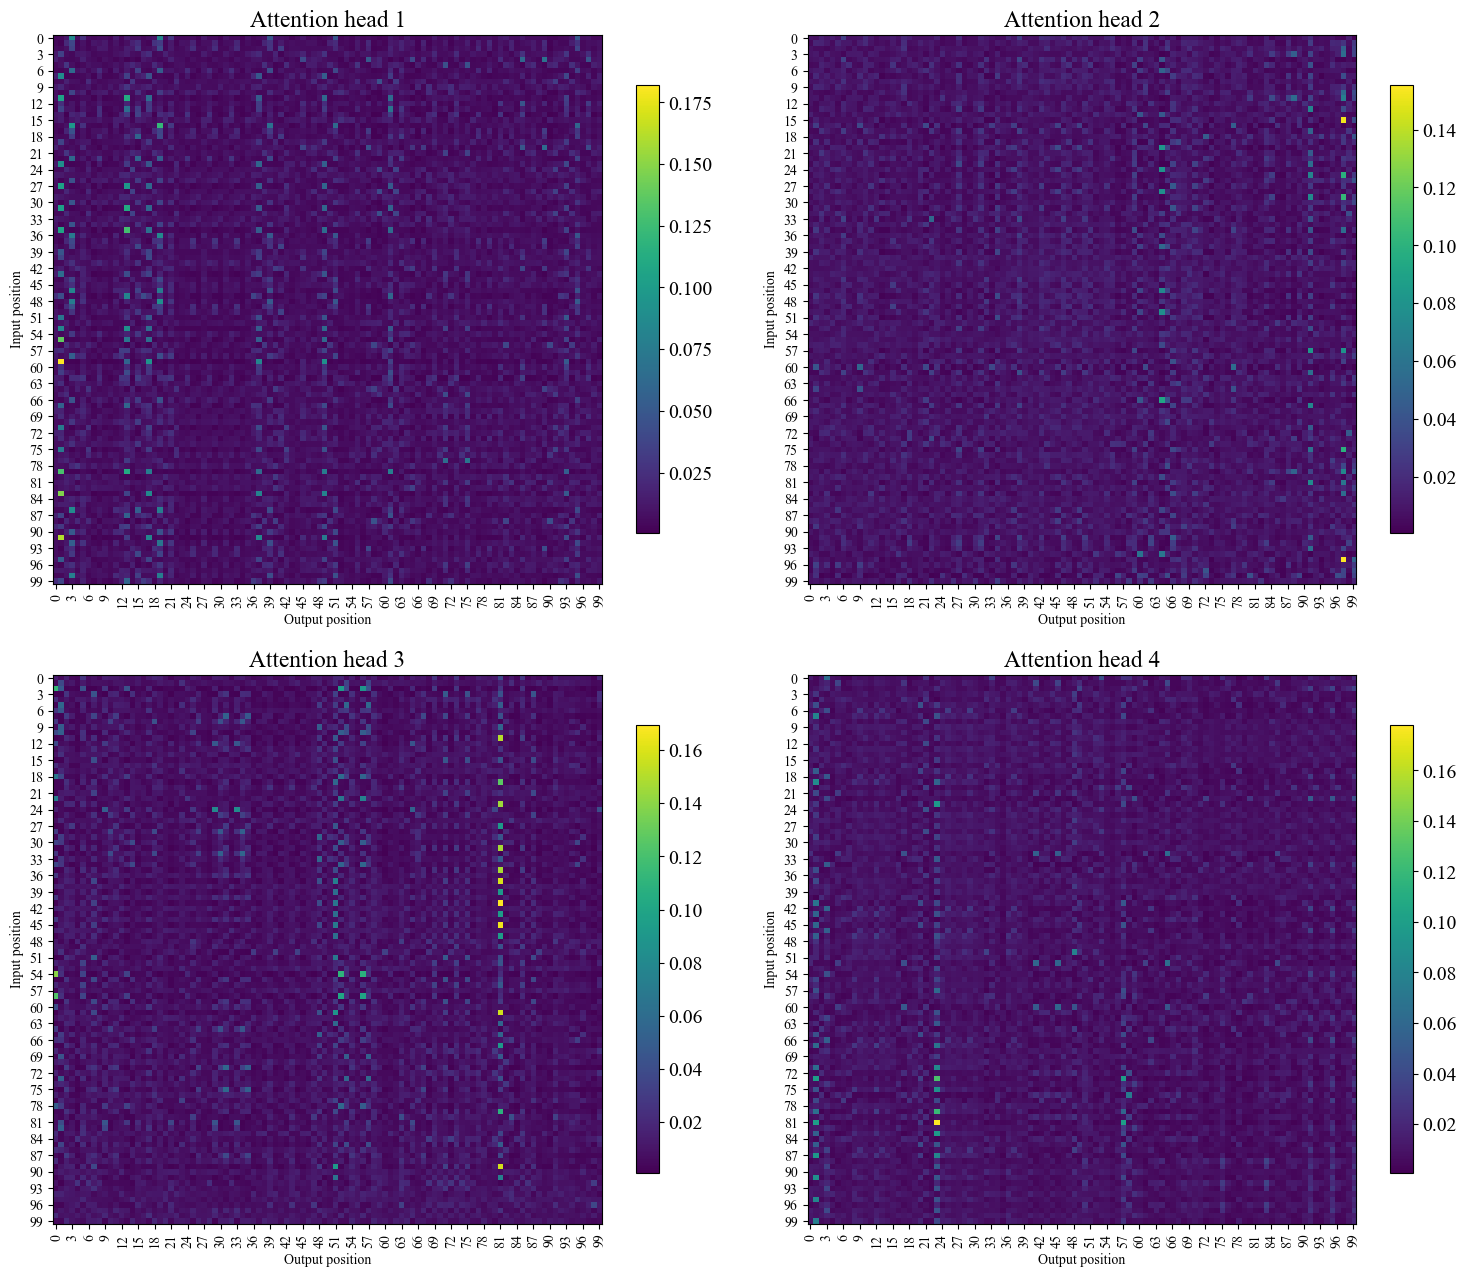

In [4]:
def show_attention_heatmap(attention_weights: np.ndarray):
    """
    多头注意力权重矩阵的热图可视化
    'viridis'：蓝白黄，逐渐加深
    'plasma'：紫红黄，逐渐加深
    'inferno'：黑红黄白，逐渐加深
    Args:
        attention_weights: np.ndarray, 注意力权重矩阵, 形状为 (num_heads, seq_length, seq_length)
    """ 
    num_heads, seq_length, _ = attention_weights.shape
    # 计算需要显示的图像数量及其排列方式, 尽量以方形显示
    num_cols = int(np.ceil(np.sqrt(num_heads)))
    num_rows = int(np.ceil(num_heads / num_cols))
    # 创建num_rows * num_cols的子图
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 8, num_rows * 8))
    mpl.rcParams.update({'font.size': 14})  

    # 把轴展平，方便后续遍历
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        head_attention = attention_weights[i, :, :]
        im = ax.imshow(head_attention, cmap='viridis')
        ax.set_xticks(range(0, seq_length, 3),range(0 ,seq_length, 3), fontsize=10,rotation=90)
        ax.set_yticks(range(0, seq_length, 3),range(0 ,seq_length, 3), fontsize=10)
        ax.tick_params(axis='both')
        ax.set_xlabel('Output position')
        ax.set_ylabel('Input position')
        ax.set_title('Attention head {}'.format(i+1))
        # 添加颜色条
        cbar = ax.figure.colorbar(im, ax=ax, shrink=0.7)
        # cbar.ax.set_ylabel('Attention weight', va='center', labelpad=10, rotation=-90)
    # 删除未使用的子图
    for i in range(num_rows * num_cols - num_heads):
        fig.delaxes(axs[-1,-(i+1)])
    # fig.tight_layout()
    fig.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0)
    return fig

fig_attention_heatmap = show_attention_heatmap(attention2)


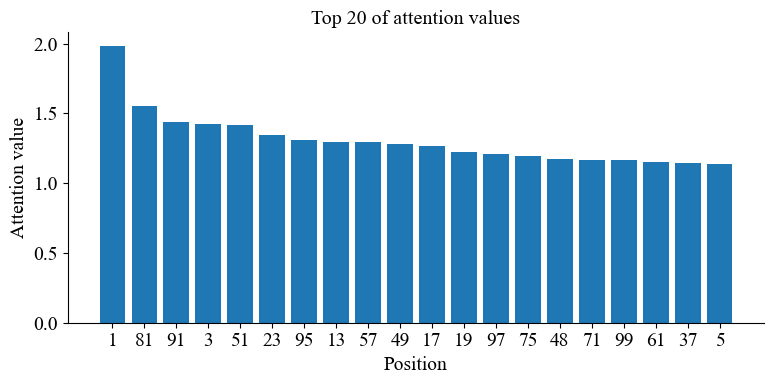

In [5]:
def show_attention_feature_ranking(attention_weights: np.ndarray, num_features=20):
    """
    注意力权重的特征重要性排序
    
    Args:
        attention_weights: np.ndarray, 注意力权重矩阵, 形状为 (num_heads, seq_length, seq_length)
        num_features: int, 显示前num_features个特征
    """ 
    # 对多头注意力权重矩阵进行平均处理
    avg_weights = np.mean(attention_weights, axis=0)
    # 计算当前位置的输出注意力值(在输入的维度求和，得到输出维度的注意力值)
    output_weights = np.sum(avg_weights, axis=0)
    # 按照注意力值对特征进行降序排序
    sorted_idx = np.argsort(output_weights)[::-1][:num_features]
    sorted_features = output_weights[sorted_idx]
    # 绘制柱状图
    fig, ax = plt.subplots(figsize=(8, 4))
    mpl.rcParams.update({'font.size': 12})  

    ax.bar(np.arange(num_features), sorted_features)
    ax.set_xticks(np.arange(num_features),[i for i in sorted_idx])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both')
    ax.set_xlabel('Position')
    ax.set_ylabel('Attention value')
    ax.set_title('Top {} of attention values'.format(num_features))
    plt.tight_layout()
    return fig

fig_feature_ranking = show_attention_feature_ranking(attention2, 20)

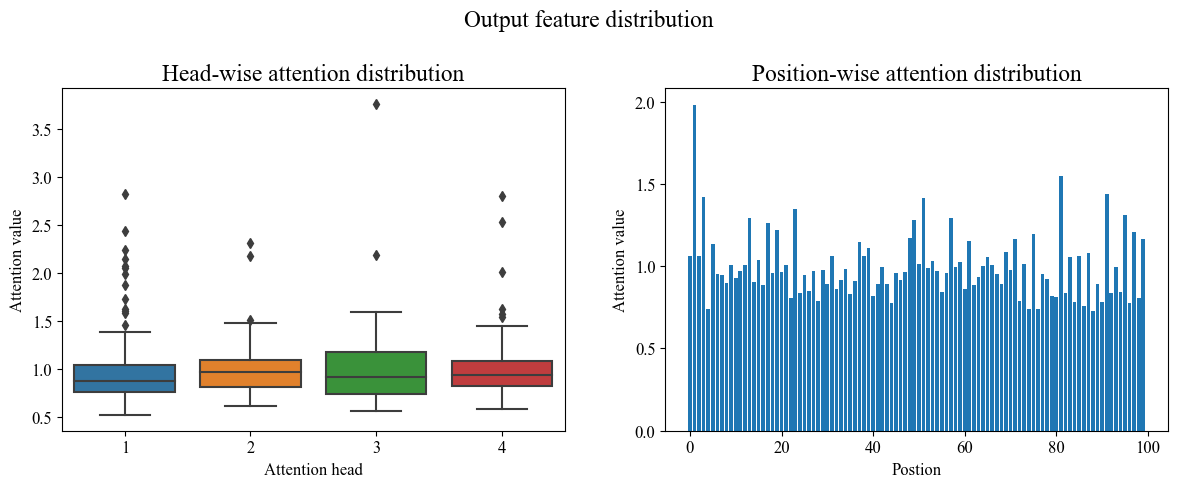

In [6]:
def show_attention_distribution(attention_weights: np.ndarray):
    """
    可视化多头注意力的输出注意力的箱线图
    
    Args:
    attention_weights: numpy array，多头注意力权重矩阵，shape为（num_heads, seq_length, seq_length）
    """
    num_heads, seq_length, _ = attention_weights.shape
    # 在输入维度求和，得到不同头下的输出位置的注意力
    output_weights = attention_weights.sum(axis=1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    mpl.rcParams.update({'font.size': 14})  

    axs = axs.flatten()
    fig.suptitle('Output feature distribution')
    # 箱线图
    sns.boxplot(data=output_weights.T, ax=axs[0])
    axs[0].set_title('Head-wise attention distribution')
    axs[0].set_xticks(np.arange(0,4), np.arange(1,5))
    axs[0].set_xlabel('Attention head')
    axs[0].set_ylabel('Attention value')
    # 柱状图
    axs[1].bar(np.arange(seq_length), output_weights.mean(axis=0))
    axs[1].set_title('Position-wise attention distribution')
    axs[1].set_xlabel('Postion')
    axs[1].set_ylabel('Attention value')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    return fig

fig_output = show_attention_distribution(attention2)

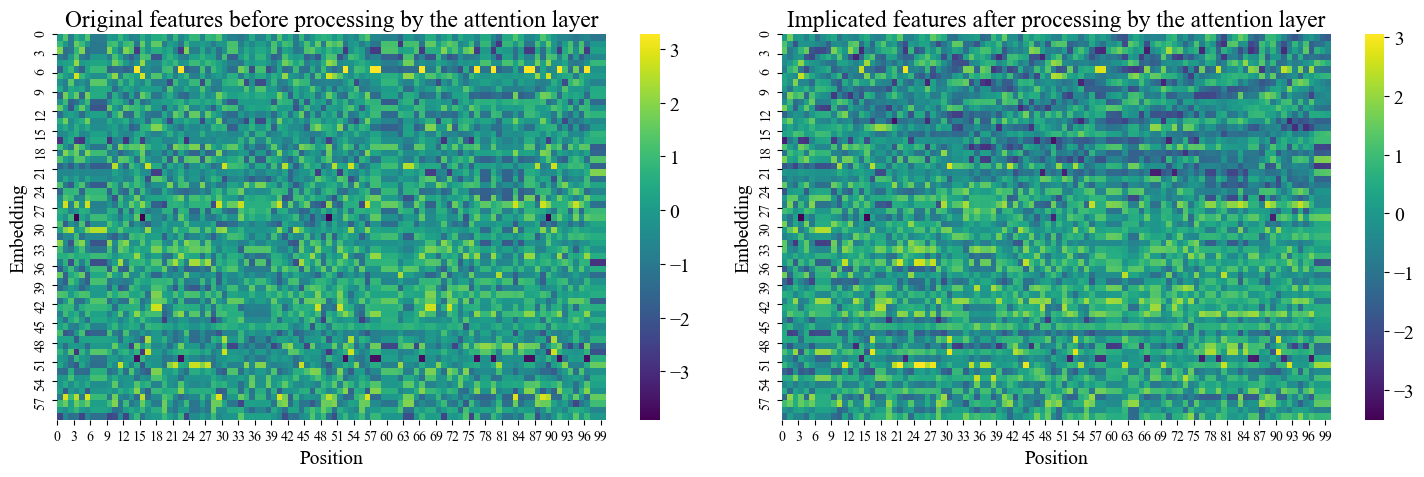

In [7]:
def show_attention_input_output(inputs: np.ndarray,outputs: np.ndarray):
    """
    可视化多头注意力的输出矩阵和输出矩阵
    
    Args:
    inputs: numpy array，多头注意力层的输入矩阵，shape为（seq_length, embedding_size）
    outputs: numpy array，多头注意力层的输出矩阵，shape为（seq_length, embedding_size）
    """
    seq_length, embedding_size = inputs.shape
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    mpl.rcParams.update({'font.size': 14})  

    axs = axs.flatten()
    # 绘制输入矩阵的热图
    sns.heatmap(inputs.T, cmap='viridis', ax=axs[0])
    axs[0].set_title('Original features before processing by the attention layer')
    axs[0].set_xlabel('Position')
    axs[0].set_ylabel('Embedding')
    axs[0].set_xticks(range(0, seq_length, 3),range(0, seq_length, 3), fontsize=10)
    axs[0].set_yticks(range(0, embedding_size, 3),range(0, embedding_size, 3), fontsize=10)
    # 绘制输出矩阵的热图
    sns.heatmap(outputs.T, cmap='viridis', ax=axs[1])
    axs[1].set_title('Implicated features after processing by the attention layer')
    axs[1].set_xlabel('Position')
    axs[1].set_ylabel('Embedding')
    axs[1].set_xticks(range(0, seq_length, 3),range(0, seq_length, 3), fontsize=10)
    axs[1].set_yticks(range(0, embedding_size, 3),range(0, embedding_size, 3), fontsize=10)
    plt.tight_layout()
    return fig

fig_input_output_features = show_attention_input_output(attention2_inputs, attention2_outputs)

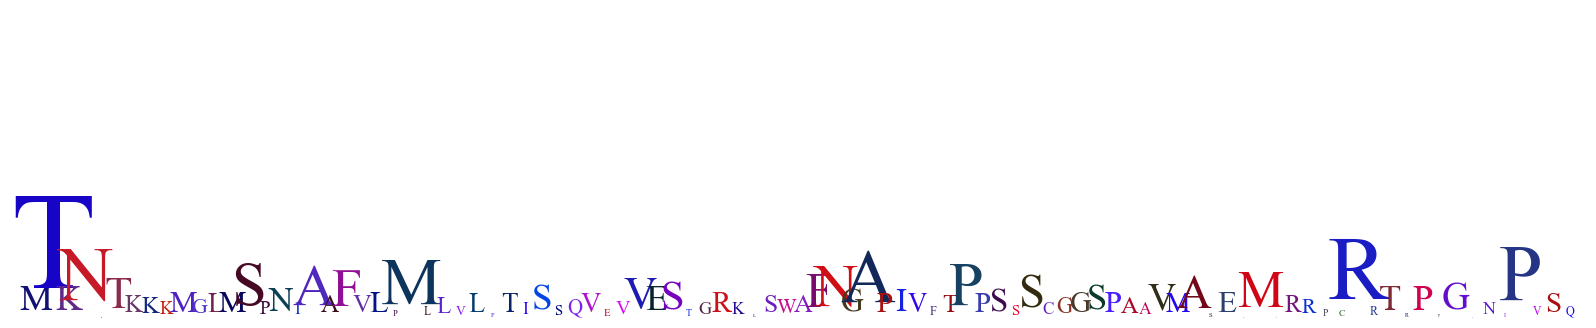

In [8]:
import random
def normalize(values):
    """
    对传入的列表进行归一化处理
    """
    min_val = min(values)  # 获取最小值
    max_val = max(values)  # 获取最大值
    if min_val == max_val:  # 处理特殊情况：所有值都相等
        return [1.0] * len(values)
    else:
        return [(val - min_val) / (max_val - min_val) for val in values]  

def generate_random_color():
    """
    生成随机rgb元组
    """
    r, g, b = np.random.randint(0,255,size=3)
    # 限制luma亮度值在70以上
    while 0.2126 * r + 0.7152 * g + 0.0722 * b > 70:
        r, g, b = np.random.randint(0,255,size=3)
    return (r/255, g/255, b/255) 

def show_attention_motifs(attention_weights, sequence, k_mer=1):
    """
    可视化注意力基序
    
    Args:
    attention_weights: numpy array，多头注意力权重矩阵，shape为（num_heads, seq_length, seq_length）
    sequence: str， 蛋白质序列
    k_mer: int, k_mer的k值
    """
    # 计算每个位置的注意力分数
    avg_attention_weights = attention_weights.mean(axis=0)
    attention_scores = avg_attention_weights.sum(axis=0)
    attention_scores = normalize(attention_scores)
    # 将序列分成若干个k-mer片段
    motif_names = [sequence[i:i+k_mer] for i in range(len(sequence)-k_mer-1)]
    num_motifs = len(motif_names)
    # 计算每一个基序应该显示的高度
    motif_size = attention_scores / np.max(attention_scores) * 100
    # 初始化图像
    fig, ax = plt.subplots(figsize=(20,4)) 
    color_dict = {}
    for i in range(num_motifs):
        # 基序竖排格式化
        motif = '\n'.join(list(motif_names[i]))
        if attention_scores[i] in color_dict:
            color = color_dict[attention_scores[i]]
        else:
            color =generate_random_color()
            color_dict[attention_scores[i]] = color
        ax.text(i, 0, motif, ha='center', va='bottom',  fontsize=motif_size[i], color=color)
    # 设置坐标轴
    ax.set_xlim(0, num_motifs)
    ax.set_ylim(0, k_mer)
    ax.axis('off')
    return fig


fig_motif = show_attention_motifs(attention2, fastas[0][1])

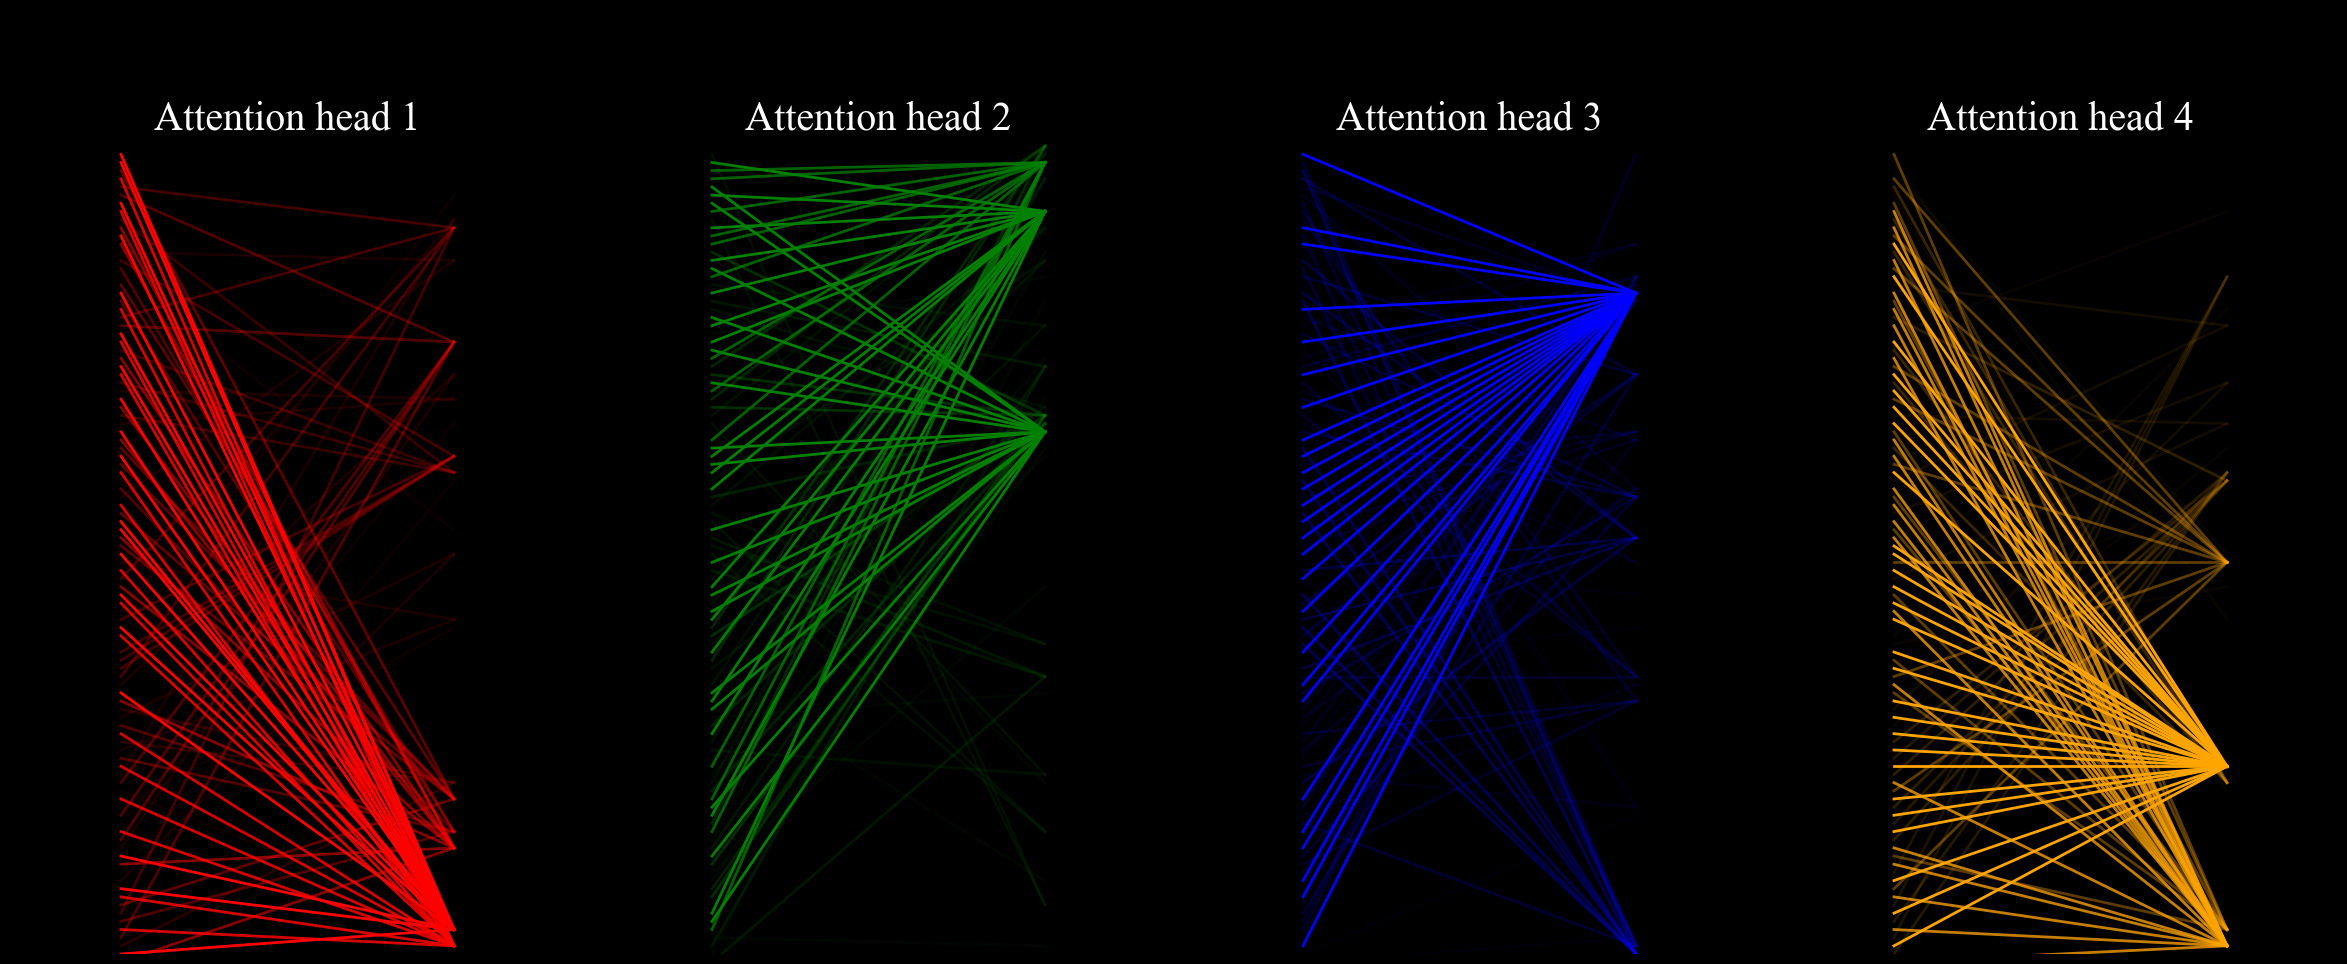

In [9]:
def show_attention_network(attention_weights: np.ndarray):
    """
    注意力网络可视化
    Args:
        attention_weights: np.ndarray, 注意力权重矩阵, 形状为 (num_heads, seq_length, seq_length)
    """ 
    num_heads, seq_length, _ = attention_weights.shape
    fig, axs = plt.subplots(1, 4, figsize=(6*4, 10),facecolor='black')
    mpl.rcParams.update({'font.size': 24})  

    fig.suptitle('Network of attention')
    colors = ['r','g','b','orange']
    for i, ax in enumerate(axs):
        head_attention = attention_weights[i, :, :]
        # 计算每个输出位置的最大注意力索引
        attention = head_attention.argmax(axis=1)
        unique_elements, counts = np.unique(attention, return_counts=True)
        # 设置线条透明度
        freq_dict = dict(zip(unique_elements, counts/max(counts)))
        for y,idx in enumerate(attention):
            ax.plot([1,4],[98-y,idx],alpha=freq_dict[idx],color=colors[i],linewidth=2)
        ax.set_title('Attention head {}'.format(i+1), color = 'white')
        ax.set_xlim(0, 5)
        ax.set_ylim(0, 100)
        ax.axis('off')    
    plt.tight_layout()
    return fig

fig_attention_network = show_attention_network(attention2)

In [10]:
fig_attention_heatmap.savefig(os.path.join(save_path_attention_visual, 'attention heatmap.png'), dpi=300, bbox_inches='tight')
fig_feature_ranking.savefig(os.path.join(save_path_attention_visual, 'feature ranking.png'), dpi=300, bbox_inches='tight')
fig_output.savefig(os.path.join(save_path_attention_visual, 'output feature distribution.png'), dpi=300, bbox_inches='tight')
fig_input_output_features.savefig(os.path.join(save_path_attention_visual, 'inputs and outputs features.png'), dpi=300, bbox_inches='tight')
fig_motif.savefig(os.path.join(save_path_attention_visual, 'motif.png'), dpi=300, bbox_inches='tight')
fig_attention_network.savefig(os.path.join(save_path_attention_visual, 'attention network.png'), dpi=300, bbox_inches='tight')
